In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.optimize
import json
import matplotlib

## Segédfüggvények

In [2]:
# determines if n is probably-prime or composite using miller rabin test. Tests k times
def is_prime(n, k=20): # miller-rabin test
    if n == 2:
        return True
    for _ in range(k):
        witness = 1
        a = random.randint(2, n-1)
        if gcd(a, n)[1] != 1:
            return False
        d = n-1
        r = 0
        while d % 2 == 0:
            d = d//2
            r += 1
        s = int_pow_mod(a, d, n)
        if s == 1:
            witness = 0
        for i in range(r):
            if s == n-1:
                witness = 0
            s = s**2 % n
        if witness == 1:
            return False
    return True

def gcd(m, n): # euclid's algorithm
    a = max(m,n)
    b = min(m,n)
    if a%b == 0:
        return a, b
    c = a % b
    return gcd(b, c) # c a legnagyobb közös osztó

In [3]:
def int_nth_root(A, n): # calculate floor of nth root of A
    if A<0:
        if n%2 == 0:
            raise ValueError
        return -int_nth_root(-A,n)
    if A==0:
        return 0
    n1 = n-1
    if A.bit_length() < 1024: # float(n) safe from overflow
        xk = int( round( pow(A,1.0/n) ) )
        xk = ( n1*xk + A//pow(xk,n1) )//n # Ensure xk >= floor(nthroot(A)).
    else:
        xk = 1 << -(-A.bit_length()//n) # 1 << sum(divmod(A.bit_length(),n))
                                        # power of 2 closer but greater than the nth root of A
    while True:
        d = A // pow(xk,n1)
        if xk <= d:
            return xk
        xk = (n1*xk + d)//n

In [4]:
def two_pow(A, k): # computes A**(2**k), A: L bit int
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 
    return result  # if k < L: max O(L^3) operations

def int_pow(A, n): # computes A**n in polynomal time, A: L bit int
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow(A, i)
    return result # if n < A: max O(L^4) operations


In [5]:
def two_pow_mod(A, k, N): #computes A**(2**k) mod N, A: L bit int
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 % N
    return result  # if  k < L: max O(L^3)

def int_pow_mod(A, n, N): #computes A**n mod N in polynomal time, A: L bit integer
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow_mod(A, i, N) % N
    return result # if n < A:max O(L^4) operations

In [6]:
def find_int_pow(N):
    n = N.bit_length()
    for i in range(2, n):
        a = int_nth_root(N, i)
        if int_pow(a, i) == N:
            return a, i
    return N, 1

def order(a, N): 
    if gcd(a, N)[1] != 1:
        raise ValueError("a and N have to be coprime")
    s = 1
    i = 0
    while i == 0 or s != 1:
        s = (a*s) % N
        i += 1
    return i

## Kapuk száma, mélység

In [7]:
def dep(n):
    return 232*n**3+282*n**2+32*n

def cx(n):
    return 16*n**4+152*n**3+188*n**2+104*n

def sing(n):
    return 24*n**4 + 176*n**3 + 230*n**2 + 139*n

In [26]:
file1 = open("complexity.txt", "r")
compl1 = json.load(file1)
file1.close()

In [9]:
file2 = open("complexity2.txt", "r")
compl2 = json.load(file2)
file2.close()

In [27]:
file3 = open("complexity3.txt", "r")
compl = json.load(file3)
file3.close()

In [32]:
np.array(list(compl2['depth'].keys()), dtype=int)

array([ 15,  21,  33,  35,  39,  45,  51,  55,  57,  63,  65,  69,  75,
        77,  85,  87,  91,  93,  95,  99, 105, 111, 115, 117, 119, 123,
       129, 133, 135, 141, 143, 145, 147, 153, 155, 159, 161, 165, 171,
       175, 177, 183, 185, 187, 189, 195, 201, 203, 205, 207, 209, 213,
       215, 217, 219, 221, 231, 235, 237, 245, 247, 249, 253, 255])

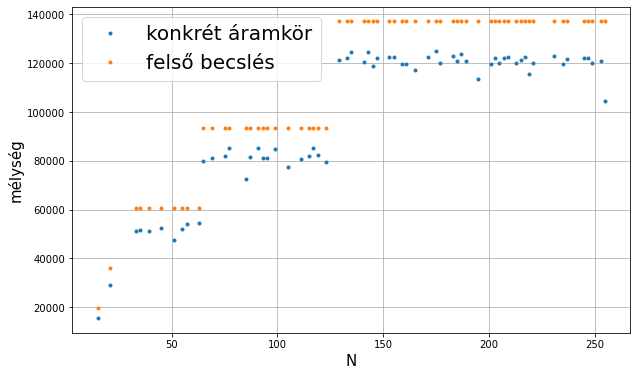

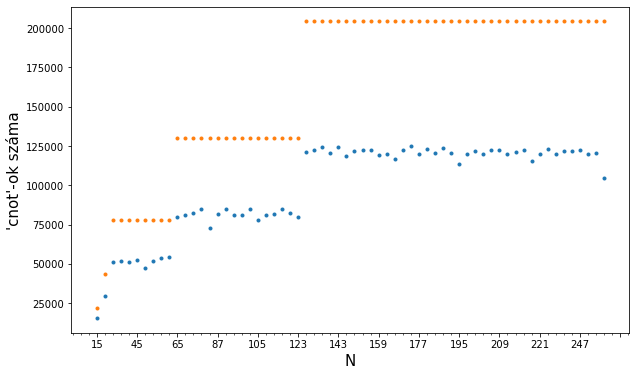

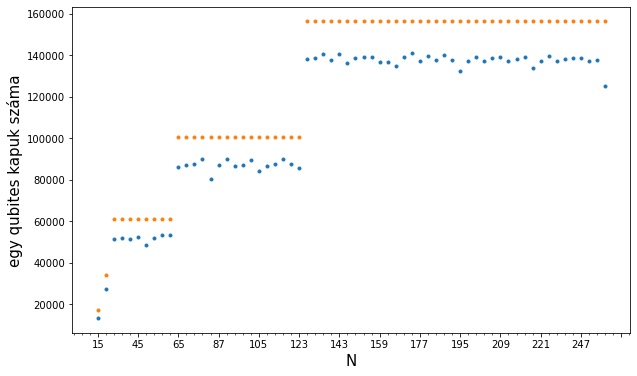

In [37]:
N_max = max(np.array(list(compl2['depth'].keys()), dtype=int))
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.array(list(compl2['depth'].keys()), dtype=int),
[max(compl2['depth'][N]) for N in compl2['depth'].keys()], '.', 
label='konkrét áramkör')
ax.plot(np.array(list(compl2['depth'].keys()), dtype=int), 
[dep(int(N).bit_length()) for N in compl2['depth'].keys()], '.', 
label='felső becslés')
ax.set_xlabel('N', fontsize=15)
ax.set_ylabel('mélység', fontsize=15)
ax.grid()
ax.legend(fontsize=20)
#plt.savefig('mélység')


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(compl2['single'].keys(), [max(compl2['depth'][N]) for N in compl2['single'].keys()], '.')
ax.plot(compl2['single'].keys(), [sing(int(N).bit_length()) for N in compl2['single'].keys()], '.')
ax.set_ylabel("'cnot'-ok száma", fontsize=15)
ax.set_xlabel('N', fontsize=15)
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(compl2['cnot'].keys(), [max(compl2['cnot'][N]) for N in compl2['cnot'].keys()], '.')
ax.plot(compl2['cnot'].keys(), [cx(int(N).bit_length()) for N in compl2['cnot'].keys()], '.')
ax.set_xlabel('N', fontsize=15)
ax.set_ylabel('egy qubites kapuk száma', fontsize=15)
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))

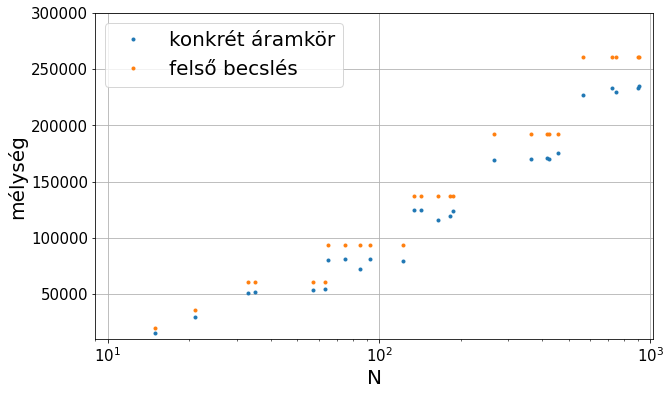

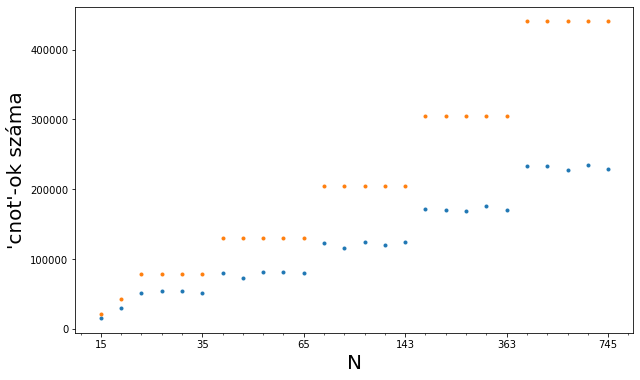

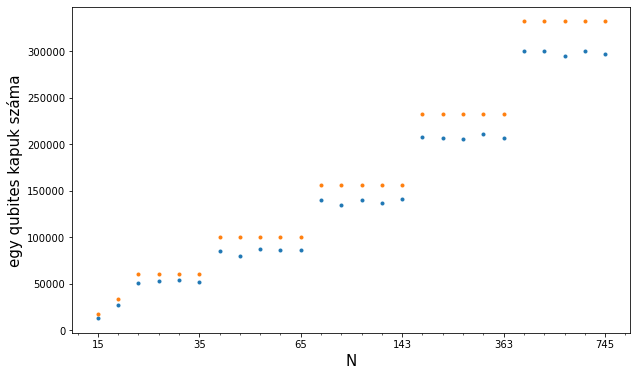

In [97]:
N_max = max(np.array(list(compl['depth'].keys()), dtype=int))
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.array(list(compl['depth'].keys()), 
dtype=int), [max(compl['depth'][N]) for N in compl['depth'].keys()], '.', 
label='konkrét áramkör')
ax.plot(np.array(list(compl['depth'].keys()), dtype=int), 
[dep(int(N).bit_length()) for N in compl['depth'].keys()], '.', 
label='felső becslés')
ax.set_xlabel('N', fontsize=20)
ax.set_ylabel('mélység', fontsize=20)
ax.grid()
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend(fontsize=20)
ax.set_xlim(9, 1024)
ax.set_ylim(10**4, 3*10**5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10))
#ax.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10))
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_formatter(matplotlib.ticker.LogFormatter(base=10, labelOnlyBase=False))
plt.savefig('mélység1')


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(compl['single'].keys(), [max(compl['depth'][N]) for N in compl['single'].keys()], '.')
ax.plot(compl['single'].keys(), [sing(int(N).bit_length()) for N in compl['single'].keys()], '.')
ax.set_ylabel("'cnot'-ok száma", fontsize=20)
ax.set_xlabel('N', fontsize=20)
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(compl['cnot'].keys(), [max(compl['cnot'][N]) for N in compl['cnot'].keys()], '.')
ax.plot(compl['cnot'].keys(), [cx(int(N).bit_length()) for N in compl['cnot'].keys()], '.')
ax.set_xlabel('N', fontsize=15)
ax.set_ylabel('egy qubites kapuk száma', fontsize=15)
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))

In [107]:
n1 = np.array([max(compl['depth'][N]) for N in compl['depth'].keys()])
n2 = np.array([dep(int(np.log2(N))+1) for N in np.array(list(compl['depth'].keys()), dtype=int)])
print(n1/n2)

[0.80018473 0.8071251  0.84213312 0.88871245 0.90237528 0.85857483
 0.8487684  0.77700869 0.87158452 0.86479096 0.85704672 0.90145016
 0.84853525 0.90874475 0.8743289  0.91072887 0.89045969 0.88648587
 0.87937563 0.913304   0.88680835 0.8963688  0.89707124 0.8711193
 0.90082911 0.88081913]


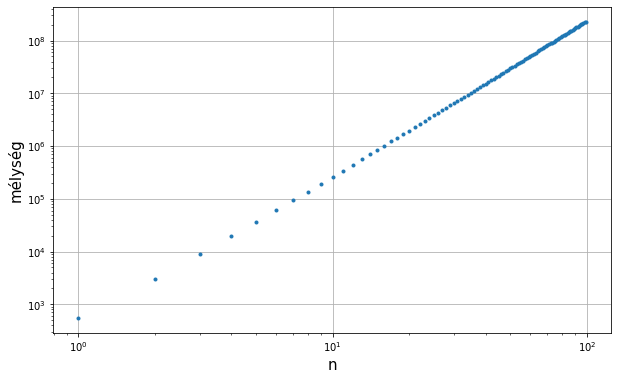

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(100), [dep(n) for n in range(100)], '.')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('n', fontsize=15)
ax.set_ylabel('mélység', fontsize=15)
ax.grid()

## futtatások száma

In [12]:
def lin(x, a, b):
    return a*x+b

def log(x, a):
    return(a*np.log2(x))

In [13]:
num = []
E = []
Expect = {}
for N in range(4, 1000):
    if is_prime(N)==False and find_int_pow(N)[1] == 1 and N%2 == 1:
        num.append(N)
        
        i = 0 # itt számláljuk, hogy hány sikeres 'a' van 
        frac = []
        for a in range(2, N-1):
            if gcd(a, N)[1] == 1:
                r = order(a, N)
                j = 0
                for s in range(1, r):
                    if gcd(s, r)[1] == 1:
                        j += 1
                frac.append(r/j)
                if r%2 == 0 and int_pow_mod(a, r//2, N) != N-1:
                    i += 1
            else:
                i += 1
                
        q = i/(N-3)
        E.append(1/(q*(N-3))*sum(frac))
        Expect[N] = 1/(q*(N-3))*sum(frac)

[0.28252494]


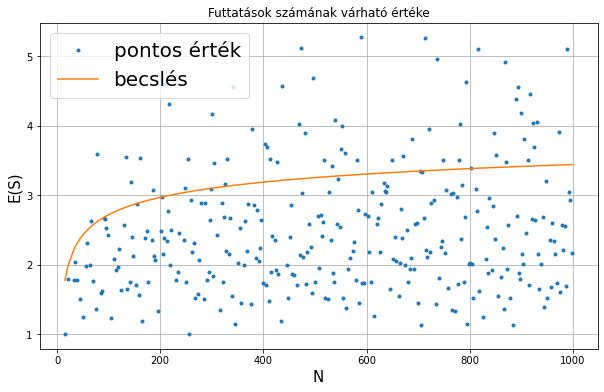

In [14]:
num = np.array(num, dtype = int)
fit, cov = scipy.optimize.curve_fit(log, num, E, p0=[1])
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(num, E, '.', label='pontos érték')
ax.set_xlabel('N', fontsize=15)
ax.set_ylabel('E(S)', fontsize=15)
ax.set_title('Futtatások számának várható értéke')
ax.grid()
ax.plot(num, np.log(np.log(num))*np.exp(np.euler_gamma), label = 'becslés')
ax.legend(fontsize=20)
#plt.savefig('E(S)')
print(fit)

### futtatások száma hibákkal

In [15]:
def expect(n, p=0): # estimate of expected value of number of runs
    P = (1-p)**(2*n+2)
    return (np.log(np.log(2))+np.log(n))*np.exp(np.euler_gamma)/P

## Várható időtartam

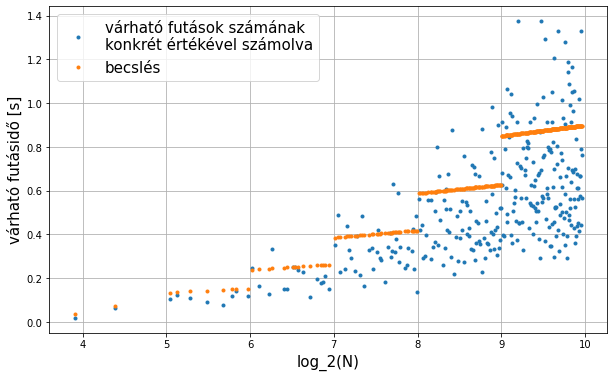

In [16]:
E = np.array(E)
power = 3
n = np.array([int(N).bit_length() for N in num])
x = num

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.log2(num), 10**-6*E*dep(n), '.', label='várható futások számának\nkonkrét értékével számolva')
ax.plot(np.log2(x), 10**-6*np.log(np.log(x))*np.exp(np.euler_gamma)*np.array([dep(int(N).bit_length()) for N in x]), '.', label='becslés')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('log_2(N)', fontsize=15)
ax.set_ylabel('várható futásidő [s]', fontsize=15)
ax.grid()
ax.legend(loc='best', fontsize=15)
#plt.savefig('futásid1')

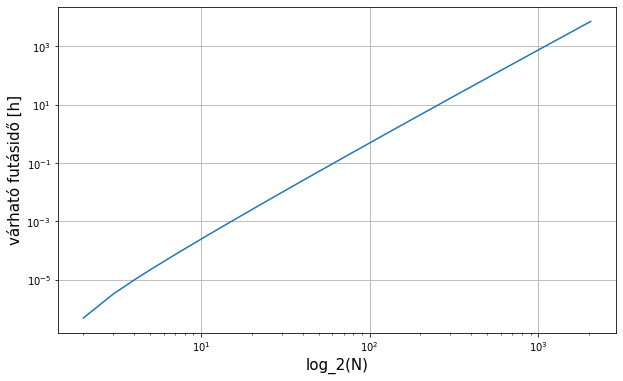

In [17]:
power = 11
n = np.arange(2, 2**power)
n = n.astype('float64')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n, 10**-6*expect(n)*dep(n)/3600, '-', label='becslés')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('log_2(N)', fontsize=15)
ax.set_ylabel('várható futásidő [h]', fontsize=15)
ax.grid()
#plt.savefig('futásid2')

In [18]:
n = 2048
10**-6*expect(n)*dep(n)/3600

7160.410609565497

## Áramkör topológiája

In [62]:
n = 4
K =1
nodes = K + 2*n + 2
lines = K*(K-1)/2 + K*(2*n+1) + 3*n*(n+1)/2 + n+1
full = nodes*(nodes-1)/2
print(full, lines)
print(15/16)
for n in range(2, 100):
    K = 2*n
    nodes = K + 2*n + 2
    lines = K*(K-1)/2 + K*(2*n+1) + 3*n*(n+1)/2 + n+1
    full = nodes*(nodes-1)/2
    print(lines/full)

55.0 44.0
0.9375
0.8444444444444444
0.8681318681318682
0.8823529411764706
0.8917748917748918
0.8984615384615384
0.903448275862069
0.9073083778966132
0.9103840682788051
0.9128919860627178
0.914975845410628
0.916734693877551
0.9182389937106918
0.9195402298850575
0.920676890534109
0.9216783216783216
0.9225672877846791
0.9233617178822658
0.9240759240759241
0.9247214694369166
0.9253077975376197
0.9258426966292135
0.9263326469915352
0.9267830843677677
0.9271986022131625
0.9275831087151842
0.9279399499582985
0.928272007452259
0.9285817760394032
0.9288714266359572
0.9291428571428572
0.9293977340488968
0.929637526652452
0.9298635353855919
0.9300769153930676
0.9302786962683042
0.9304697986577182
0.9306510482981071
0.930823187938402
0.9309868875086267
0.9311427528294998
0.9312913331012879
0.9314331273669524
0.9315685901098204
0.9316981361180257
0.9318221447253705
0.9319409635199108
0.9320549115966027
0.9321642824180896
0.9322693463376188
0.9323703528297419
0.9324675324675324
0.9325610986793033
0.